# Programmazione di Applicazioni Data Intensive: Progetto 

- Candidato: Fabrizio Margotta
- Dataset: [Malicious and Benign Websites](https://www.kaggle.com/xwolf12/malicious-and-benign-websites) by Christian Urcuqui

## Introduzione

## Analisi esplorativa

In [1]:
# setup e test librerie
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import io
import seaborn as sns
sns.set();
import sklearn

In [2]:
dtypes = {
    'CHARSET': 'category',
    'SERVER': 'category',
    'WHOIS_COUNTRY': 'category',
    'WHOIS_STATEPRO': 'category',
}

In [3]:
DS_URL = "https://gitlab.com/emrevoid/uni/dia/project/famar/-/raw/master/dataset.csv"
#https://stackoverflow.com/questions/51092889/receiving-http-error-403-forbidden-csv-download/51093473
response = requests.get(DS_URL)
file_object = io.StringIO(response.content.decode('utf-8'))

ds = pd.read_csv(file_object, header=0, index_col=0, sep=';', dtype=dtypes)
ds['WHOIS_REGDATE'] = pd.to_datetime(ds['WHOIS_REGDATE'], errors='coerce')
ds['WHOIS_UPDATED_DATE'] = pd.to_datetime(ds['WHOIS_UPDATED_DATE'], errors='coerce')
ds = ds.rename(columns={"Type": "malicious"})
ds.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
URL,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,iso-8859-1,nginx,263.00,None,None,2015-10-10 18:21:00,NaT,7,0,2,700,9,10,1153,832,9,2.00,1
B0_2314,16,6,UTF-8,Apache/2.4.10,15087.00,None,None,NaT,NaT,17,7,4,1230,17,19,1265,1230,17,0.00,0
B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.00,None,None,NaT,NaT,0,0,0,0,0,0,0,0,0,0.00,0
B0_113,17,6,ISO-8859-1,nginx,162.00,US,AK,1997-07-10 04:00:00,2013-12-09 00:45:00,31,22,3,3812,39,37,18784,4380,39,8.00,0
B0_403,17,6,UTF-8,None,124140.00,US,TX,1996-12-05 00:00:00,2017-11-04 00:00:00,57,2,5,4278,61,62,129889,4586,61,4.00,0


- **URL**: it is the anonimous identification of the URL analyzed in the study
- **URL_LENGTH**: it is the number of characters in the URL
- **NUMBER_SPECIAL_CHARACTERS**: it is number of special characters identified in the URL, such as, “/”, “%”, “#”, “&”, “. “, “=”
- **CHARSET**: it is a categorical value and its meaning is the character encoding standard (also called character set).
- **SERVER**: it is a categorical value and its meaning is the operative system of the server got from the packet response.
- **CONTENT_LENGTH**: it represents the content size of the HTTP header.
- **WHOIS_COUNTRY**: it is a categorical variable, its values are the countries we got from the server response (specifically, our script used the API of Whois).
- **WHOIS_STATEPRO**: it is a categorical variable, its values are the states we got from the server response (specifically, our script used the API of Whois).
- **WHOIS_REGDATE**: Whois provides the server registration date, so, this variable has date values with format DD/MM/YYY HH:MM
- **WHOIS_UPDATED_DATE**: Through the Whois we got the last update date from the server analyzed
- **TCP_CONVERSATION_EXCHANGE**: This variable is the number of TCP packets exchanged between the server and our honeypot client
- **DIST_REMOTETCP_PORT**: it is the number of the ports detected and different to TCP
- **REMOTE_IPS**: this variable has the total number of IPs connected to the honeypot
- **APP_BYTES**: this is the number of bytes transfered
- **SOURCE_APP_PACKETS**: packets sent from the honeypot to the server
- **REMOTE_APP_PACKETS**: packets received from the server
- **APP_PACKETS**: this is the total number of IP packets generated during the communication between the honeypot and the server
- **DNS_QUERY_TIMES**: this is the number of DNS packets generated during the communication between the honeypot and the server
- **malicious**: this is a categorical variable, its values represent the type of web page analyzed, specifically, 1 is for malicious websites and 0 is for benign websites

In [4]:
ds.shape

(1781, 20)

In [5]:
ds["malicious"].value_counts()

0    1565
1     216
Name: malicious, dtype: int64

In [6]:
ds["malicious"].value_counts(normalize=True)

0   0.88
1   0.12
Name: malicious, dtype: float64

In [7]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['SERVER'].value_counts()

malicious  SERVER                                                                                                                                                                     
0          Apache                                                                                                                                                                         295
           None                                                                                                                                                                           175
           nginx                                                                                                                                                                          162
           Microsoft-HTTPAPI/2.0                                                                                                                                                          110
           cloudflare-nginx                              

In [8]:
ds['CHARSET'].unique()
ds['CHARSET']=np.where(ds['CHARSET'] == 'iso-8859-1', 'ISO-8859-1', ds['CHARSET'])
ds['CHARSET']=np.where(ds['CHARSET'] == 'ISO-8859', 'ISO-8859-1', ds['CHARSET'])
ds['CHARSET']=np.where(ds['CHARSET'] == 'utf-8', 'UTF-8', ds['CHARSET'])

In [9]:
ds['WHOIS_COUNTRY'].unique()
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'United Kingdom', 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == "[u'GB', u'UK']", 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'United Kingdom', 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'us', 'US', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'se', 'SE', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'ru', 'RU', ds['WHOIS_COUNTRY'])

In [10]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['CHARSET'].value_counts()

malicious  CHARSET     
0          UTF-8           903
           ISO-8859-1      504
           us-ascii        151
           None              6
           windows-1252      1
1          UTF-8           152
           ISO-8859-1       58
           us-ascii          4
           None              1
           windows-1251      1
Name: CHARSET, dtype: int64

In [11]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['WHOIS_COUNTRY'].value_counts()

malicious  WHOIS_COUNTRY
0          US               1056
           None              241
           CA                 82
           AU                 35
           PA                 19
           GB                 15
           UK                 15
           JP                 11
           IN                  9
           FR                  8
           CN                  7
           CH                  6
           NL                  6
           AT                  4
           BS                  4
           PH                  4
           SE                  4
           BE                  3
           HK                  3
           KR                  3
           KY                  3
           SC                  3
           TR                  3
           Cyprus              2
           DE                  2
           IL                  2
           KG                  2
           NO                  2
           SI                  2
           AE     

In [12]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['WHOIS_STATEPRO'].value_counts()

malicious  WHOIS_STATEPRO      
0          CA                      369
           None                    290
           NY                       75
           WA                       63
           FL                       60
           Arizona                  56
           California               45
           ON                       43
           NV                       30
           UT                       29
           CO                       23
           MA                       21
           PA                       20
           IL                       19
           PANAMA                   17
           MO                       15
           NJ                       15
           Ohio                     15
           Queensland               14
           New York                 11
           TX                       10
           VA                       10
           Quebec                    9
           Texas                     9
           DC                   

In [13]:
ds.describe()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
count,1781.00,1781.00,969.00,1781.00,1781.00,1781.00,1781.00,1781.00,1781.00,1781.00,1781.00,1781.00,1780.00,1781.00
mean,56.96,11.11,11726.93,16.26,5.47,3.06,2982.34,18.54,18.75,15892.55,3155.60,18.54,2.26,0.12
std,27.56,4.55,36391.81,40.50,21.81,3.39,56050.57,41.63,46.40,69861.93,56053.78,41.63,2.93,0.33
min,16.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,39.00,8.00,324.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,49.00,10.00,1853.00,7.00,0.00,2.00,672.00,8.00,9.00,579.00,735.00,8.00,0.00,0.00
75%,68.00,13.00,11323.00,22.00,5.00,5.00,2328.00,26.00,25.00,9806.00,2701.00,26.00,4.00,0.00
max,249.00,43.00,649263.00,1194.00,708.00,17.00,2362906.00,1198.00,1284.00,2060012.00,2362906.00,1198.00,20.00,1.00


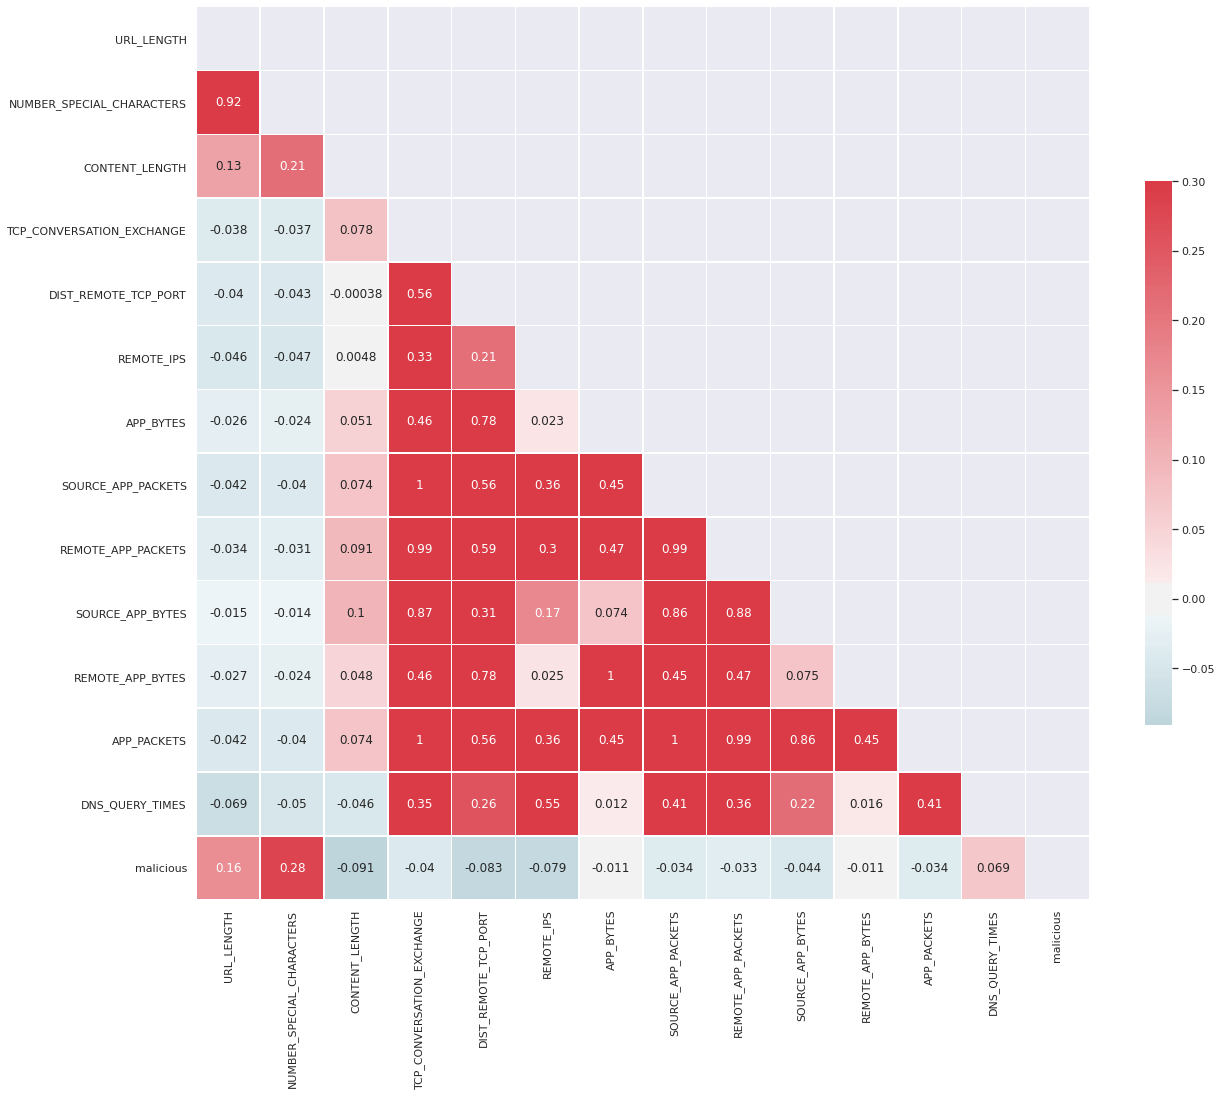

In [14]:
# Compute the correlation matrix
corr = ds.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

Il grafico mostra la correlazione tra le feature su cui è possibile fare una prima analisi:

- innanzitutto la classe `malicious` sembra essere influenzata dal numero di caratteri speciali nell'URL e dalla lunghezza dell'URL stesso, **e ciò è plausibile poiché tipicamente gli URL vengono offuscati o ne viene presentata**
- il numero di caratteri dell'URL è correlato al numero di caratteri speciali dell'URL, ancora una volta per ragioni di offuscamento di quest'ultimo
- il numero di pacchetti (al livello applicativo) mandati dall'honeypot al server (`SOURCE_APP_PACKETS`) e il numero di pacchetti TCP scambiati durante la conversazione tra i due nodi (`TCP_CONVERSATION_EXCHANGE`) sono chiaramente correlati se assumiamo che gli applicativi (ad esempio un client e server web) hanno scambiato dati basandosi su canali di comunicazione TCP (ad esempio pagine web mediante HTTP)
  - allo stesso modo per le feature `REMOTE_APP_BYTES`, `APP_BYTES` (quindi il numero di byte totali trasferiti) e `APP_PACKETS` (il numero totale di pacchetti IP scambiati)
- contestualmente è possibile osservare la correlazione tra la porta di destinazione e il numero di pacchetti / byte scambiati, che può essere associato alla natura del servizio utilizzato che con buona probabilità comprende l'utilizzo di un protocollo che preveda un numero prefissato di pacchetti per l'instaurazione della comunicazione e dello scambio dei dati

In [15]:
ds.nunique()

URL_LENGTH                   142
NUMBER_SPECIAL_CHARACTERS     31
CHARSET                        6
SERVER                       239
CONTENT_LENGTH               637
WHOIS_COUNTRY                 44
WHOIS_STATEPRO               182
WHOIS_REGDATE                888
WHOIS_UPDATED_DATE           593
TCP_CONVERSATION_EXCHANGE    103
DIST_REMOTE_TCP_PORT          66
REMOTE_IPS                    18
APP_BYTES                    825
SOURCE_APP_PACKETS           113
REMOTE_APP_PACKETS           116
SOURCE_APP_BYTES             885
REMOTE_APP_BYTES             822
APP_PACKETS                  113
DNS_QUERY_TIMES               10
malicious                      2
dtype: int64

In [16]:
ds['SERVER'].value_counts()[:20]

Apache                                                                                       386
nginx                                                                                        211
None                                                                                         175
Microsoft-HTTPAPI/2.0                                                                        113
cloudflare-nginx                                                                              94
Microsoft-IIS/7.5                                                                             51
GSE                                                                                           49
Server                                                                                        49
YouTubeFrontEnd                                                                               42
nginx/1.12.0                                                                                  36
ATS                           

Riduciamo la dimensionalità della variabile categorica `SERVER`:

In [17]:
ds['SERVER'] = np.where(ds['SERVER'].str.contains('Apache/'), 'Apache', ds['SERVER'])
ds['SERVER'] = np.where(ds['SERVER'].str.contains('nginx/'), 'nginx', ds['SERVER'])
ds['SERVER'] = np.where(ds['SERVER'].str.contains('Microsoft-'), 'Microsoft', ds['SERVER'])

### Binarizzazione delle feature categoriche

In [18]:
ds['SERVER'].value_counts()[:3]

Apache       623
nginx        337
Microsoft    198
Name: SERVER, dtype: int64

In [19]:
tmp = ds[ds['SERVER'].isin(ds.SERVER.value_counts()[3:].index)]
ds[ds['SERVER'].isin(ds.SERVER.value_counts()[3:].index)]

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
URL,,,,,,,,,,,,,,,,,,,,
B0_403,17,6,UTF-8,None,124140.00,US,TX,1996-12-05 00:00:00,2017-11-04 00:00:00,57,2,5,4278,61,62,129889,4586,61,4.00,0
B0_22,20,7,UTF-8,None,13716.00,GB,None,2002-11-10 00:00:00,2016-06-10 00:00:00,16,6,8,1492,20,20,2334,1784,20,4.00,0
B0_161,22,6,UTF-8,openresty/1.11.2.1,nan,US,CA,1999-03-07 00:00:00,2015-07-08 00:00:00,39,29,6,3833,43,42,22495,4125,43,4.00,0
B0_1412,23,7,ISO-8859-1,Oracle-iPlanet-Web-Server/7.0,3257.00,None,None,2000-10-13 00:00:00,2017-04-27 00:00:00,0,0,0,0,0,0,0,0,0,0.00,0
B0_2217,23,6,ISO-8859-1,None,6748.00,US,Arizona,1999-12-31 00:00:00,2017-09-04 00:00:00,7,4,5,630,7,4,244,630,7,0.00,0
B0_23,23,6,None,None,nan,US,TX,1996-07-30 00:00:00,2016-04-07 00:00:00,19,7,6,2404,23,20,6179,2684,23,4.00,0
B0_241,23,6,UTF-8,None,nan,GB,None,2008-09-05 00:00:00,2015-11-27 00:00:00,19,14,6,1980,23,25,5737,2276,23,4.00,0
B0_285,23,6,UTF-8,None,nan,US,WI,1999-04-23 00:00:00,2016-07-25 00:00:00,4,0,1,519,8,8,1138,823,8,4.00,0
B0_465,23,6,UTF-8,cloudflare-nginx,nan,US,Oregon,1997-04-02 00:00:00,2014-08-11 00:00:00,10,0,5,1186,14,15,1900,1476,14,4.00,0


In [20]:
tmp['malicious'].value_counts()

0    611
1     12
Name: malicious, dtype: int64

In [21]:
tmp.shape

(623, 20)

In [22]:
tmp2 = ds[ds['SERVER'].isin(ds.SERVER.value_counts()[:3].index)] # OK!
tmp2['malicious'].value_counts()

0    954
1    204
Name: malicious, dtype: int64

In [23]:
tmp2.shape

(1158, 20)

In [24]:
ds = ds.drop(ds[ds['SERVER'].isin(ds.SERVER.value_counts()[3:].index)].index)
ds

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
URL,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,ISO-8859-1,nginx,263.00,None,None,2015-10-10 18:21:00,NaT,7,0,2,700,9,10,1153,832,9,2.00,1
B0_2314,16,6,UTF-8,Apache,15087.00,None,None,NaT,NaT,17,7,4,1230,17,19,1265,1230,17,0.00,0
B0_911,16,6,us-ascii,Microsoft,324.00,None,None,NaT,NaT,0,0,0,0,0,0,0,0,0,0.00,0
B0_113,17,6,ISO-8859-1,nginx,162.00,US,AK,1997-07-10 04:00:00,2013-12-09 00:45:00,31,22,3,3812,39,37,18784,4380,39,8.00,0
B0_2064,18,7,UTF-8,nginx,nan,SC,Mahe,2016-03-08 14:30:00,2016-03-10 03:45:00,11,6,9,894,11,13,838,894,11,0.00,0
B0_462,18,6,ISO-8859-1,Apache,345.00,US,CO,2002-07-29 00:00:00,2016-01-07 00:00:00,12,0,3,1189,14,13,8559,1327,14,2.00,0
B0_1128,19,6,us-ascii,Microsoft,324.00,US,FL,1997-03-18 00:00:00,2017-03-19 00:00:00,0,0,0,0,0,0,0,0,0,0.00,0
M2_17,20,5,UTF-8,nginx,nan,None,None,2014-08-11 07:41:00,NaT,0,0,0,0,2,3,213,146,2,2.00,1
M3_75,20,5,UTF-8,nginx,nan,None,None,2014-08-11 07:41:00,NaT,0,0,0,0,2,1,62,146,2,2.00,1


In [25]:
ds['malicious'].value_counts()

0    954
1    204
Name: malicious, dtype: int64

In [26]:
dtype_categories = ['SERVER']
ds = pd.get_dummies(ds, columns=dtype_categories, prefix=dtype_categories)

Rimozione di valori fuori "scala" che non permettono di visualizzare correttamente alcuni scatterplot (poiché "appiattiscono" la distribuzione).

In [27]:
pd.set_option('display.max_rows', 20)
ds = ds.drop(ds.index[ds.APP_BYTES > 40000])
ds.sort_values('APP_BYTES')['APP_BYTES']

URL
M4_13          0
B0_822         0
B0_1122        0
B0_1245        0
B0_1286        0
           ...  
B0_682     15162
B0_304     18084
M0_121     20074
B0_222     23383
B0_481     26631
Name: APP_BYTES, Length: 1157, dtype: int64

In [28]:
ds['CHARSET'].value_counts()[:3]

UTF-8         622
ISO-8859-1    398
us-ascii      132
Name: CHARSET, dtype: int64

In [29]:
tmp = ds[ds['CHARSET'].isin(ds.CHARSET.value_counts()[:3].index)]
ds[ds['CHARSET'].isin(ds.CHARSET.value_counts()[:3].index)]

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,...,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious,SERVER_Apache,SERVER_Microsoft,SERVER_nginx
URL,,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,ISO-8859-1,263.00,None,None,2015-10-10 18:21:00,NaT,7,0,...,9,10,1153,832,9,2.00,1,0,0,1
B0_2314,16,6,UTF-8,15087.00,None,None,NaT,NaT,17,7,...,17,19,1265,1230,17,0.00,0,1,0,0
B0_911,16,6,us-ascii,324.00,None,None,NaT,NaT,0,0,...,0,0,0,0,0,0.00,0,0,1,0
B0_113,17,6,ISO-8859-1,162.00,US,AK,1997-07-10 04:00:00,2013-12-09 00:45:00,31,22,...,39,37,18784,4380,39,8.00,0,0,0,1
B0_2064,18,7,UTF-8,nan,SC,Mahe,2016-03-08 14:30:00,2016-03-10 03:45:00,11,6,...,11,13,838,894,11,0.00,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M4_45,194,17,UTF-8,nan,ES,Barcelona,2008-09-17 00:00:00,2016-02-09 00:00:00,0,0,...,0,3,186,0,0,0.00,1,1,0,0
M4_48,194,16,UTF-8,nan,ES,Barcelona,2008-09-17 00:00:00,2016-02-09 00:00:00,0,0,...,0,3,186,0,0,0.00,1,1,0,0
M4_41,198,17,UTF-8,nan,ES,Barcelona,2008-09-17 00:00:00,2016-02-09 00:00:00,0,0,...,0,2,124,0,0,0.00,1,1,0,0


In [30]:
ds = ds.drop(ds[ds['CHARSET'].isin(ds.CHARSET.value_counts()[3:].index)].index)
dtype_categ_charset = ['CHARSET']
ds = pd.get_dummies(ds, columns=dtype_categ_charset, prefix=dtype_categ_charset)

In [31]:
ds

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,...,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious,SERVER_Apache,SERVER_Microsoft,SERVER_nginx,CHARSET_ISO-8859-1,CHARSET_UTF-8,CHARSET_us-ascii
URL,,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,263.00,None,None,2015-10-10 18:21:00,NaT,7,0,2,...,832,9,2.00,1,0,0,1,1,0,0
B0_2314,16,6,15087.00,None,None,NaT,NaT,17,7,4,...,1230,17,0.00,0,1,0,0,0,1,0
B0_911,16,6,324.00,None,None,NaT,NaT,0,0,0,...,0,0,0.00,0,0,1,0,0,0,1
B0_113,17,6,162.00,US,AK,1997-07-10 04:00:00,2013-12-09 00:45:00,31,22,3,...,4380,39,8.00,0,0,0,1,1,0,0
B0_2064,18,7,nan,SC,Mahe,2016-03-08 14:30:00,2016-03-10 03:45:00,11,6,9,...,894,11,0.00,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M4_45,194,17,nan,ES,Barcelona,2008-09-17 00:00:00,2016-02-09 00:00:00,0,0,0,...,0,0,0.00,1,1,0,0,0,1,0
M4_48,194,16,nan,ES,Barcelona,2008-09-17 00:00:00,2016-02-09 00:00:00,0,0,0,...,0,0,0.00,1,1,0,0,0,1,0
M4_41,198,17,nan,ES,Barcelona,2008-09-17 00:00:00,2016-02-09 00:00:00,0,0,0,...,0,0,0.00,1,1,0,0,0,1,0


In [78]:
features = ['URL_LENGTH',
            'NUMBER_SPECIAL_CHARACTERS',
            'APP_BYTES',
            'CONTENT_LENGTH',
            'TCP_CONVERSATION_EXCHANGE',
            'SOURCE_APP_PACKETS',
            'REMOTE_APP_PACKETS',
            'DNS_QUERY_TIMES']

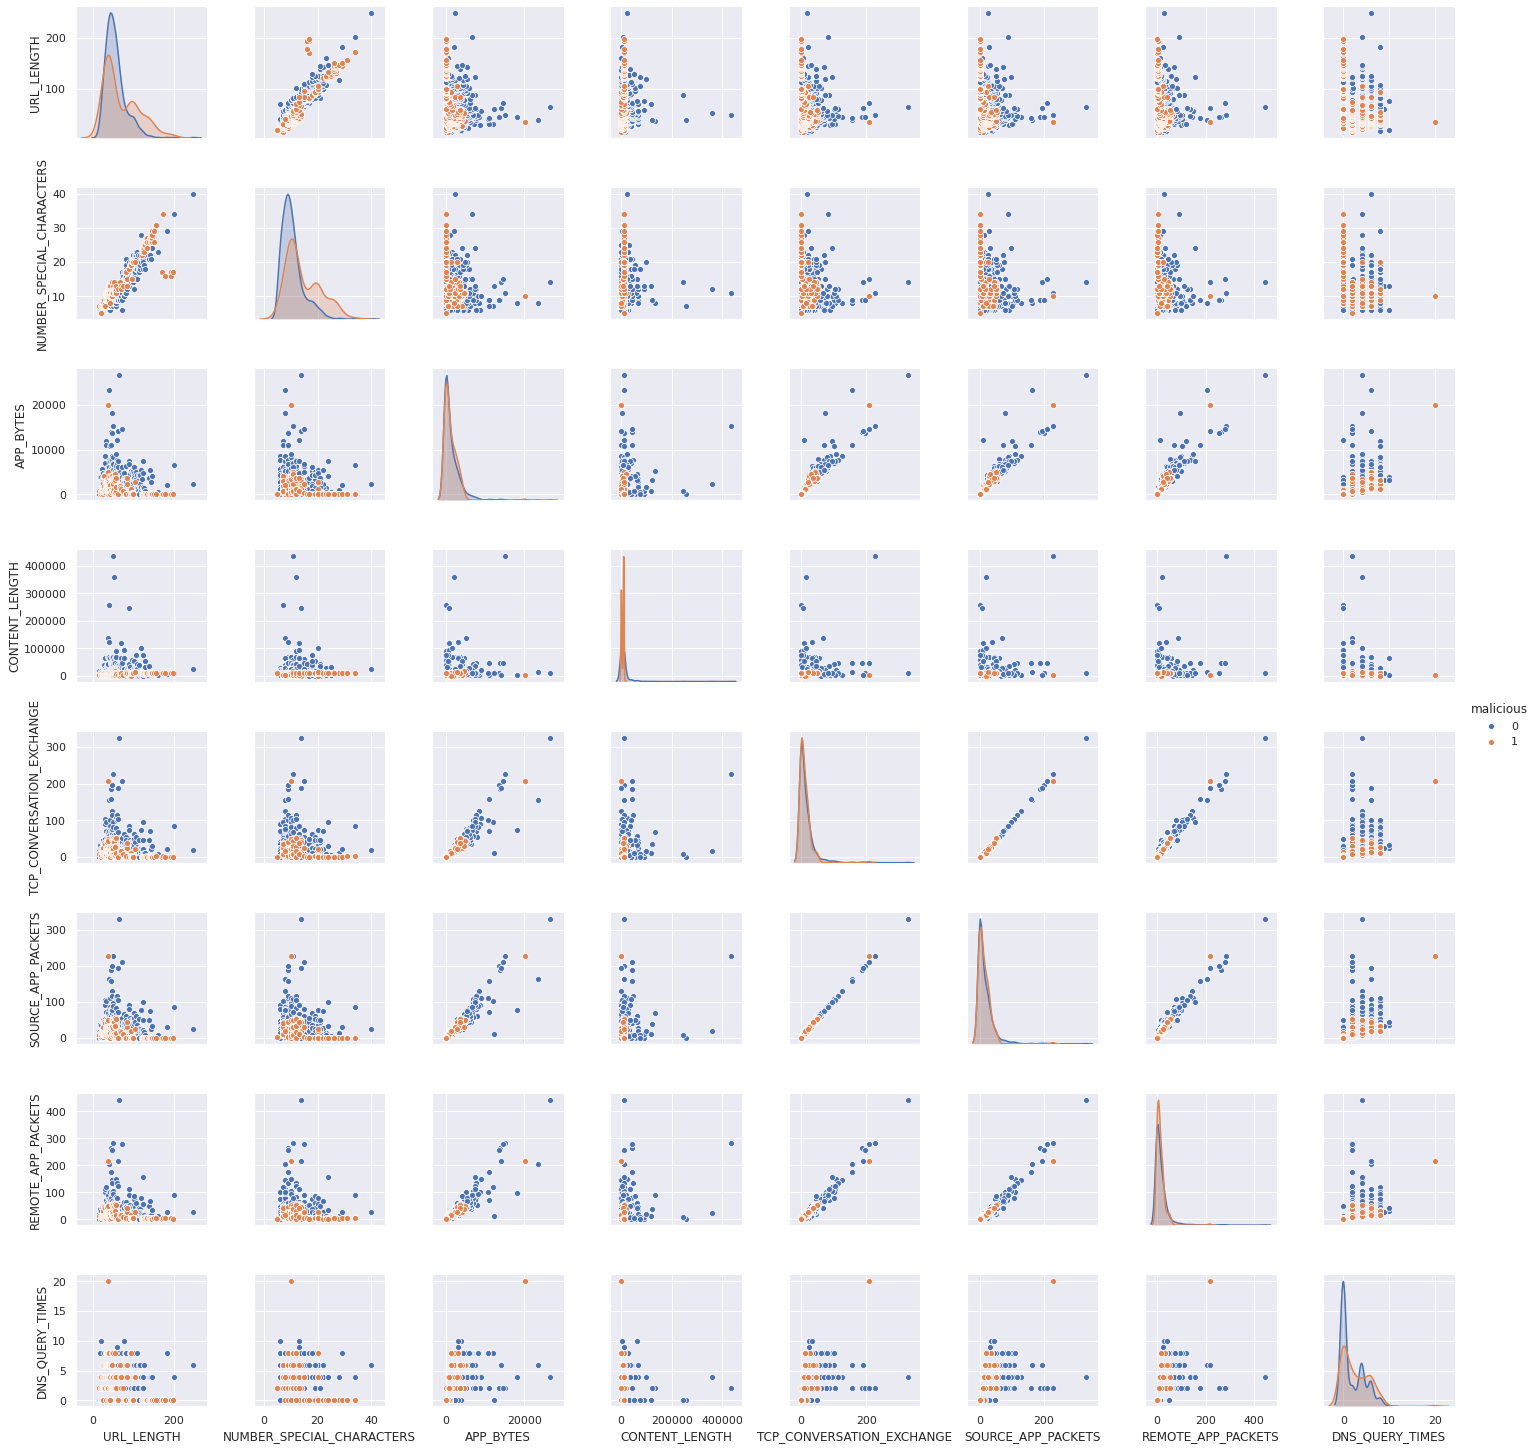

In [80]:
sns.set();
sns.pairplot(data=ds, hue="malicious", vars=features);

I grafici in diagonale mostrano la distribuzione dei dati rispetto alla feature in oggetto, da cui possiamo osservare che i siti malevoli hanno URL più lunghi e con più caratteri speciali rispetto ai siti non malevoli.

Gli altri grafici a dispersione mostrano che sono possibili diverse classificazioni lineari tra le diverse feature, mentre altre (soprattutto quelle in cui è presente la colonna `DNS_QUERY_TIMES`) possono richiedere sforzi ulteriori, come classificazioni non lineari.

## Preparazione del dataset

### Gestione di valori nulli

Verifichiamo che nel dataset siano presenti valori nulli:

In [34]:
pd.set_option('display.max_rows', None)
ds.isna().sum()

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CONTENT_LENGTH               422
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                114
WHOIS_UPDATED_DATE           124
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
malicious                      0
SERVER_Apache                  0
SERVER_Microsoft               0
SERVER_nginx                   0
CHARSET_ISO-8859-1             0
CHARSET_UTF-8                  0
CHARSET_us-ascii               0
dtype: int64

Usiamo il metodo `.fillna()`:
- per le feature numeriche sostituiamo i valori nulli con le medie

In [35]:
ds['CONTENT_LENGTH'].fillna(ds['CONTENT_LENGTH'].mean(), inplace=True)
ds['DNS_QUERY_TIMES'].fillna(ds['DNS_QUERY_TIMES'].mean(), inplace=True)

- per le feature temporali (`WHOIS_REGDATE` e `WHOIS_UPDATED_DATE`) usiamo i parametri `ffill` o `bfill`

In [36]:
ds['WHOIS_REGDATE'].fillna(method="ffill", inplace=True)
ds['WHOIS_UPDATED_DATE'].fillna(method="ffill", inplace=True)
ds['WHOIS_UPDATED_DATE'].fillna(method="bfill", inplace=True)

Verifichiamo di aver risolto il problema dei valori nulli:

In [37]:
ds.isna().sum()

URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
malicious                    0
SERVER_Apache                0
SERVER_Microsoft             0
SERVER_nginx                 0
CHARSET_ISO-8859-1           0
CHARSET_UTF-8                0
CHARSET_us-ascii             0
dtype: int64

In [38]:
X = ds.drop(['WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE', 'malicious'], axis=1)
y = ds['malicious']

### Risoluzione problema classi sbilanciate

In [39]:
ds.shape

(1152, 24)

In [40]:
ds["malicious"].value_counts()

0    950
1    202
Name: malicious, dtype: int64

In [41]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 950), (1, 950)]


In [42]:
sns.set();
ds_oversampled = pd.concat([X_resampled, y_resampled], axis=1)

In [43]:
ds.shape

(1152, 24)

In [44]:
ds_oversampled["malicious"].value_counts()

1    950
0    950
Name: malicious, dtype: int64

In [45]:
ds_oversampled["malicious"].value_counts(normalize=True)

1   0.50
0   0.50
Name: malicious, dtype: float64

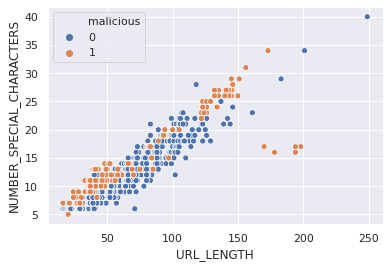

In [134]:
ds_ordered = ds.sort_values('malicious')
ax = sns.scatterplot(x="URL_LENGTH", y="NUMBER_SPECIAL_CHARACTERS", hue="malicious", data=ds_ordered)

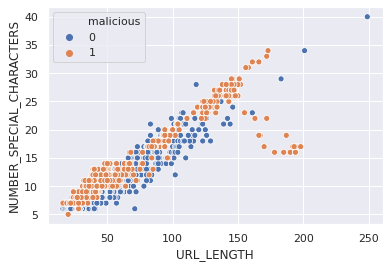

In [135]:
ds_oversampled_ordered = ds_oversampled.sort_values('malicious')
ax = sns.scatterplot(x="URL_LENGTH", y="NUMBER_SPECIAL_CHARACTERS", hue="malicious", data=ds_oversampled_ordered)

## Classificazione

Separazione del dataset:

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=1/3,
    random_state=42,
)

Stratified K fold: preparazione dell'oggetto:

In [48]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(3, shuffle=True, random_state=42)
for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

0    214
1    208
Name: malicious, dtype: int64
0    214
1    208
Name: malicious, dtype: int64
0    214
1    208
Name: malicious, dtype: int64


### Perceptron

Perceptron in pipeline con grid search su Standardizzazione, feature polinomiali (gradi da 1 a 5) e regolarizzazione in un intervallo con 5 valori da 10^-2 a 10^2.

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import GridSearchCV

In [50]:
scale = [None, StandardScaler()]
polynomial = [PolynomialFeatures(include_bias=False)]
grid = [
    {
        "std" : scale,
        "perceptron__penalty": ["l2", "l1", "elasticnet"],
        "perceptron__alpha": np.logspace(-2, 2, 5)
    },
]

model_perceptron = Pipeline([
    ('std', None),
    ('poly', PolynomialFeatures()),
    ('perceptron', Perceptron(random_state=42))
])

gs_perceptron = GridSearchCV(model_perceptron, grid, cv=skf)
gs_perceptron.fit(X_train, y_train);

In [51]:
print('Accuracy on train {:.2f}%'.format(gs_perceptron.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_perceptron.score(X_val, y_val)*100))
print(gs_perceptron.best_params_)

Accuracy on train 86.10%
Accuracy on val 88.01%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l1', 'std': StandardScaler()}


Grazie all'utilizzo della regolarizzazione è possibile osservare quali feature hanno influenzato di più l'accuratezza del modello:

In [127]:
pd.Series(gs_perceptron.best_estimator_[2].coef_[0],
          index=gs_perceptron.best_estimator_[1].get_feature_names(X_train.columns)).sort_values(ascending=False)

APP_PACKETS^2                                           25.16
SOURCE_APP_PACKETS APP_PACKETS                          25.16
SOURCE_APP_PACKETS^2                                    25.16
TCP_CONVERSATION_EXCHANGE APP_PACKETS                   24.59
TCP_CONVERSATION_EXCHANGE SOURCE_APP_PACKETS            24.59
TCP_CONVERSATION_EXCHANGE^2                             19.73
CHARSET_ISO-8859-1 CHARSET_UTF-8                         7.38
NUMBER_SPECIAL_CHARACTERS                                6.70
SERVER_Apache SERVER_nginx                               6.26
SERVER_Microsoft CHARSET_UTF-8                           5.60
NUMBER_SPECIAL_CHARACTERS CHARSET_UTF-8                  4.32
DNS_QUERY_TIMES                                          2.40
URL_LENGTH SERVER_Apache                                 0.93
TCP_CONVERSATION_EXCHANGE DIST_REMOTE_TCP_PORT           0.00
CONTENT_LENGTH CHARSET_us-ascii                          0.00
CONTENT_LENGTH CHARSET_UTF-8                             0.00
CONTENT_

Addestriamo lo stesso modello sui DataFrame contenenti le classi sbilanciate:

In [52]:
X_train_unb, X_val_unb, y_train_unb, y_val_unb = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42,
)

In [53]:
# Perceptron with standard scaler
model_perceptron_unb = Pipeline([
    ('std', None),
    ("poly", PolynomialFeatures()),
    ('perceptron', Perceptron(random_state=42))
])

gs_perceptron_unb = GridSearchCV(model_perceptron_unb, grid, cv=skf)
gs_perceptron_unb.fit(X_train_unb, y_train_unb);

In [54]:
print('Accuracy on train {:.2f}%'.format(gs_perceptron_unb.score(X_train_unb, y_train_unb)*100))
print('Accuracy on val {:.2f}%'.format(gs_perceptron_unb.score(X_val_unb, y_val_unb)*100))
print(gs_perceptron_unb.best_params_)

Accuracy on train 85.55%
Accuracy on val 83.59%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l1', 'std': StandardScaler()}


#### Matrice di confusione

Calcoliamo la matrice di confusione sia per il DataSet originale con classi sbilanciate che con quello in cui le classi sono state bilanciate tramite SMOTE.

In [55]:
def compute_confusion_matrix(model, X_val, y_val):
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(X_val)
    return confusion_matrix(y_val, y_pred)

In [56]:
# https://www.kaggle.com/agungor2/various-confusion-matrix-plots#1.-Seaborn-Heatmap-
def plot_confusion_matrix(model, X_val, y_val, y_train, label_X='Actual', label_y='Predicted'):
    cm = compute_confusion_matrix(model, X_val, y_val)
    df_cm = pd.DataFrame(cm, columns=np.unique(y_train), index = np.unique(y_train))
    df_cm.index.name = label_X
    df_cm.columns.name = label_y
    plt.figure(figsize = (4,3));
    sns.set(font_scale=1.4); #for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

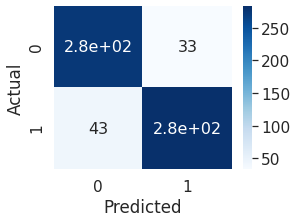

In [57]:
plot_confusion_matrix(gs_perceptron, X_val, y_val, y_train)

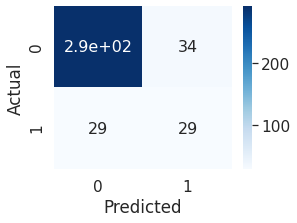

In [58]:
plot_confusion_matrix(gs_perceptron_unb, X_val_unb, y_val_unb, y_train_unb)

#### Precision e recall

In [59]:
from sklearn.metrics import classification_report

Balanced:

In [60]:
y_pred = gs_perceptron.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       308
           1       0.90      0.87      0.88       326

    accuracy                           0.88       634
   macro avg       0.88      0.88      0.88       634
weighted avg       0.88      0.88      0.88       634



Unbalanced:

In [61]:
y_pred_unb = gs_perceptron.predict(X_val_unb)
print(classification_report(y_val_unb, y_pred_unb))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       326
           1       0.57      0.69      0.62        58

    accuracy                           0.88       384
   macro avg       0.76      0.80      0.78       384
weighted avg       0.89      0.88      0.88       384



### Regressione logistica

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

In [63]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "logreg__penalty": ["l1"],
        "logreg__C": np.logspace(-2, 2, 5)
    },
]

# Perceptron with standard scaler
model_logreg = Pipeline([
    ('std', None),
    ('logreg', LogisticRegression(solver="saga", dual=False, random_state=42, max_iter=10000))
])

gs_logreg = GridSearchCV(model_logreg, grid, cv=skf)
gs_logreg.fit(X_train, y_train)

Accuracy on train 89.73%
Accuracy on val 91.01%
{'logreg__C': 10.0, 'logreg__penalty': 'l1', 'std': StandardScaler()}


In [ ]:
print('Accuracy on train {:.2f}%'.format(gs_logreg.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_logreg.score(X_val, y_val)*100))
print(gs_logreg.best_params_)

In [108]:
pd.Series(gs_logreg.best_estimator_[1].coef_[0], index=X_train.columns).sort_values(ascending=False)

REMOTE_APP_PACKETS           4.50
NUMBER_SPECIAL_CHARACTERS    1.84
DNS_QUERY_TIMES              0.64
SOURCE_APP_PACKETS           0.61
APP_PACKETS                  0.61
TCP_CONVERSATION_EXCHANGE    0.48
APP_BYTES                   -0.30
URL_LENGTH                  -0.54
REMOTE_APP_BYTES            -0.57
REMOTE_IPS                  -1.49
SERVER_Microsoft            -1.85
CHARSET_us-ascii            -2.25
SERVER_nginx                -2.56
CHARSET_UTF-8               -2.65
SERVER_Apache               -2.83
CHARSET_ISO-8859-1          -3.01
CONTENT_LENGTH              -3.01
DIST_REMOTE_TCP_PORT        -5.36
SOURCE_APP_BYTES            -5.97
dtype: float64

In [64]:
y_pred_logreg = gs_logreg.predict(X_val)
print(classification_report(y_val, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       308
           1       0.90      0.93      0.91       326

    accuracy                           0.91       634
   macro avg       0.91      0.91      0.91       634
weighted avg       0.91      0.91      0.91       634



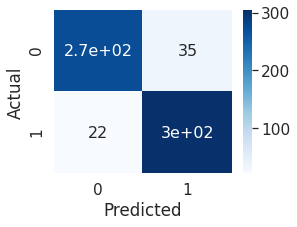

In [65]:
plot_confusion_matrix(gs_logreg, X_val, y_val, y_train)

### SVM

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

In [67]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "svm__C": np.logspace(-3, 3, 5)
    },
]

# Perceptron with standard scaler
model_svm = Pipeline([
    ('std', None),
    ('svm', SVC())
])

gs_svm = GridSearchCV(model_svm, grid, cv=skf)
gs_svm.fit(X_train, y_train)

Accuracy on train 97.39%
Accuracy on val 96.85%
{'std': StandardScaler(), 'svm__C': 31.622776601683793}


In [109]:
print('Accuracy on train {:.2f}%'.format(gs_svm.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_svm.score(X_val, y_val)*100))
print(gs_svm.best_params_)

Accuracy on train 97.39%
Accuracy on val 96.85%
{'std': StandardScaler(), 'svm__C': 31.622776601683793}


In [115]:
pd.Series(gs_svm.best_estimator_[1].support_vectors_[0], index=X_train.columns).sort_values(ascending=False)

DNS_QUERY_TIMES              2.05
REMOTE_APP_BYTES             1.63
SERVER_nginx                 1.60
REMOTE_IPS                   1.54
APP_BYTES                    1.54
APP_PACKETS                  1.20
SOURCE_APP_PACKETS           1.20
DIST_REMOTE_TCP_PORT         1.10
TCP_CONVERSATION_EXCHANGE    1.03
CHARSET_UTF-8                0.84
REMOTE_APP_PACKETS           0.49
NUMBER_SPECIAL_CHARACTERS    0.29
URL_LENGTH                   0.28
SOURCE_APP_BYTES             0.04
CHARSET_us-ascii            -0.28
SERVER_Microsoft            -0.37
CONTENT_LENGTH              -0.47
CHARSET_ISO-8859-1          -0.60
SERVER_Apache               -1.01
dtype: float64

In [68]:
y_pred_svm = gs_svm.predict(X_val)
print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       308
           1       0.96      0.98      0.97       326

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



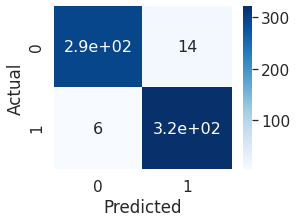

In [69]:
plot_confusion_matrix(gs_svm, X_val, y_val, y_train)

## Confronto tra i modelli

In [70]:
def diff_interval(a1, a2, N1, N2, Z):
    sigma1 = a1 * (1 - a1) / N1
    sigma2 = a2 * (1 - a2) / N2
    sigma = np.sqrt(sigma1 + sigma2)
    diff = abs(a1 - a2)
    Z_sigma = Z * sigma
    return (diff - Z_sigma, diff + Z_sigma)

In [71]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    from scipy.stats import norm
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N1 = len(X)
    N2 = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N1, N2, Z)

In [73]:
model_diff_interval(gs_perceptron, gs_perceptron_unb, X_val, y_val)

(0.1116115823327584, 0.19753668265146856)

In [74]:
model_diff_interval(gs_perceptron, gs_logreg, X_val, y_val)

(-0.0037217032062331137, 0.06365861172358334)

In [75]:
model_diff_interval(gs_perceptron, gs_svm, X_val, y_val)

(0.05961628862921172, 0.11703986279034664)

In [76]:
model_diff_interval(gs_logreg, gs_svm, X_val, y_val)

(0.03226599492585981, 0.08445324797634833)